# Setup

In [6]:
# run this code, then re-start runtime 
!python -m spacy download en_core_web_md &> /dev/null

In [2]:
conda install -c conda-forge spacy

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import spacy
# md: reduced word vector table with 20k unique vectors for ~500k words
nlp = spacy.load("en_core_web_md") # IF THIS DOESN'T WORK, THEN RUN THE CODE ABOVE^ & RE-START RUNTIME

In [28]:
# import dependencies
import pandas as pd
import numpy as np
import nltk
import re
import itertools
import matplotlib.pyplot as plt

## nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk import pos_tag

# spacy
import spacy
# md: reduced word vector table with 20k unique vectors for ~500k words

## sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

# xgboost
from xgboost import XGBClassifier

## joblib
from joblib import dump, load

##ensemble learning
from sklearn.ensemble import VotingClassifier

# set seed
np.random.seed(42)

[nltk_data] Downloading package stopwords to /Users/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# load data 
train = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Train.csv', header=0)
val = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Val.csv', header=0)
test = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/original%20data/Constraint_Test.csv', header=0)

In [ ]:
#print(f"The training set contains {len(train)} observations.")
#train.head()

In [32]:
# Define X & y for train, validation, & test sets 
X_train = train["tweet"]
y_train = train["label"]

X_val = val["tweet"]
y_val = val["label"]

X_test = test["tweet"]
y_test = test["label"]

# This code drops posts longer than 280 characters: 
#X_train = train[train["tweet"].map(len) <= 280]

# Drop duplicates:
# #X_train = train["tweet"].drop_duplicates()

In [7]:
# define print_metrics() function to print results
def print_metrics(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Accuracy : ",accuracy_score(pred,true))
    print("Precison : ",precision_score(pred,true, average = 'weighted'))
    print("Recall : ",recall_score(pred,true,  average = 'weighted'))
    print("F1 : ",f1_score(pred,true,  average = 'weighted'))

In [8]:
# define plot_confusion_matrix() function to display results
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

# Pre-processing

In [33]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

# create stop word list
from spacy.lang.en.stop_words import STOP_WORDS
stoplist = list(STOP_WORDS)

# create CleanText() function
def CleanText(string):
    text = string.lower() # lowercase
    #text = text.split() #  splits into a list of words
    #text = " ".join(text) # joins the list of words
    # .split() + .join() cancel each other out -- consider removing?
    text = re.sub(r"http(\S)+",' ',text) # remove URLs   
    text = re.sub(r"www(\S)+",' ',text) # remove URLs
    text = re.sub(r"&",' and ',text) # replace & with ' and '
    text = text.replace('&amp',' ') # replace &amp with ' '
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text) # remove non-alphanumeric characters
    text = text.split() # splits into a list of words
    text = [w for w in text if not w in stoplist] # remove stop words
    text = [lemmatizer.lemmatize(w) for w in text] # lemmatization
    text = " ".join(text) # joins the list of words
    return text

# apply CleanText() function to all tweets 
X_train = X_train.map(lambda x: CleanText(x))
X_val = X_val.map(lambda x: CleanText(x))
X_test = X_test.map(lambda x: CleanText(x))

[nltk_data] Downloading package wordnet to /Users/marco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
# Import label encoder
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'label'.
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
y_test = label_encoder.fit_transform(y_test)

# Feature Extraction


## Word Embeddings

In [35]:
# generate word vectors for each tweet 
## train set 
tweet2vec_list = [nlp(doc).vector.reshape(1,-1) for doc in X_train] # creates 6420x1 list, with each entry containing a 300x1 np.array word vector corresponding with a tweet
tweet2vec_data = np.concatenate(tweet2vec_list) # joins word vectors into 6420x300 np.array
tweet2vec_train = pd.DataFrame(tweet2vec_data) # convert to data frame

## validation set 
tweet2vec_list = [nlp(doc).vector.reshape(1,-1) for doc in X_val] # creates 6420x1 list, with each entry containing a 300x1 np.array word vector corresponding with a tweet
tweet2vec_data = np.concatenate(tweet2vec_list) # joins word vectors into 6420x300 np.array
tweet2vec_val = pd.DataFrame(tweet2vec_data) # convert to data frame

## test set 
tweet2vec_list = [nlp(doc).vector.reshape(1,-1) for doc in X_test] # creates 6420x1 list, with each entry containing a 300x1 np.array word vector corresponding with a tweet
tweet2vec_data = np.concatenate(tweet2vec_list) # joins word vectors into 6420x300 np.array
tweet2vec_test = pd.DataFrame(tweet2vec_data) # convert to data frame

## Bag-of-Words (BoW)

In [36]:
# count vectorizer
cv = CountVectorizer(ngram_range=(1, 2)) # count term frequency

# fit and transform train data to count vectorizer
cv.fit(X_train.values)
cv_train = cv.transform(X_train.values)

# fit and transform validation data to counter vectorizer
cv_val = cv.transform(X_val.values)

# fit and transform validation data to counter vectorizer
cv_test = cv.transform(X_test.values)

In [37]:
# rename word2vec columns to de-conflict merge

## train set
### create list of word embedding column names
word2vec_col = []
for i in range(len(tweet2vec_train.columns)):
  num = str(i)
  name = "word2vec_"+num
  word2vec_col.append(name) 

### rename word embedding columns 
tweet2vec_train.columns = word2vec_col

## validation set
### create list of word embedding column names
word2vec_col = []
for i in range(len(tweet2vec_val.columns)):
  num = str(i)
  name = "word2vec_"+num
  word2vec_col.append(name) 

### rename word embedding columns 
tweet2vec_val.columns = word2vec_col

## test set
### create list of word embedding column names
word2vec_col = []
for i in range(len(tweet2vec_test.columns)):
  num = str(i)
  name = "word2vec_"+num
  word2vec_col.append(name) 

### rename word embedding columns 
tweet2vec_test.columns = word2vec_col

## TF-IDF

In [40]:
# TF-IDF
tfidf = TfidfTransformer()

# fit the CountVector to TF-IDF transformer
tfidf.fit(cv_train)
tfidf_train = tfidf.transform(cv_train)

# do the same for the validation set
tfidf.fit(cv_val)
tfidf_val = tfidf.transform(cv_val)

# and the same for the validation set
tfidf.fit(cv_test)
tfidf_test = tfidf.transform(cv_test)

In [41]:
# convert tfidf_train to data frame
## train set
tfidf_train = pd.DataFrame(tfidf_train.toarray())

## validation set 
tfidf_val = pd.DataFrame(tfidf_val.toarray())

## test set 
tfidf_test = pd.DataFrame(tfidf_test.toarray())

In [42]:
# rename tfidf columns to de-conflict merge

## train set
### create list of tfidf column names
tfidf_col = []
for i in range(len(tfidf_train.columns)):
  num = str(i)
  name = "tfidf_"+num
  tfidf_col.append(name) 

### rename tfidf columns
tfidf_train.columns = tfidf_col

## validation set
### create list of tfidf column names
tfidf_col = []
for i in range(len(tfidf_val.columns)):
  num = str(i)
  name = "tfidf_"+num
  tfidf_col.append(name) 

### rename tfidf columns
tfidf_val.columns = tfidf_col

## test set
### create list of tfidf column names
tfidf_col = []
for i in range(len(tfidf_test.columns)):
  num = str(i)
  name = "tfidf_"+num
  tfidf_col.append(name) 

### rename tfidf columns
tfidf_test.columns = tfidf_col

## Combine Features

In [43]:
# join tf-idf with word embeddings 

## train set 
X_train = tfidf_train.join(tweet2vec_train) 

## validation set 
X_val = tfidf_val.join(tweet2vec_val) 

## test set 
X_test = tfidf_test.join(tweet2vec_test) 

# Model Training

## #1 SVM

In [21]:
# SVM classifier
#svm_clf = SVC(kernel='linear',probability=True)

# train model
#fit = svm_clf.fit(X_train,y_train) # train model

# make predictions
#svm_pred = svm_clf.predict(X_val)

In [ ]:
# SVM classifier
svm_clf = SVC(kernel='linear',probability=True)

# create pipeline
pipeline = Pipeline([
        #('bow', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        #('tfidf', TfidfTransformer()), # downweight words which appear frequently
        ('c', svm_clf) # classifier
    ])

# train model
fit = pipeline.fit(X_train,y_train)

# make predictions
print('SVM')
print ('val:')
pred = pipeline.predict(X_val)

# display results
print_metrics(pred,y_val)
plot_confusion_matrix(confusion_matrix(y_val,pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

[[ 951   69]
 [  54 1066]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1020
           1       0.94      0.95      0.95      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140

Accuracy :  0.9425233644859813
Precison :  0.9426595755124478
Recall :  0.9425233644859813
F1 :  0.9425450769376004


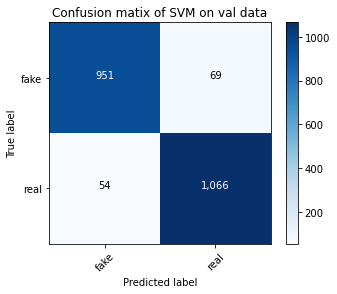

In [27]:
# display results
print_metrics(pred,y_val)
plot_confusion_matrix(confusion_matrix(y_val,pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

## #2 Logistic Regression

In [28]:
# create logistic regression object
lr_clf = LogisticRegression(max_iter=1000, penalty='none', solver='saga')

# create pipeline
#pipeline = Pipeline([
        #('count', CountVectorizer(ngram_range=(1, 2))), # count term frequency
        #('tfidf', TfidfTransformer()), # downweight words which appear frequently
        #('c', lr_clf) # classifier
    #])

# train model
fit = lr_clf.fit(X_train,y_train)

# make predictions
pred_lr = lr_clf.predict(X_val) 

# display results
print_metrics(pred_lr, y_val)
plot_confusion_matrix(confusion_matrix(y_val,pred_lr),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on val data')

/Users/marco/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## #3 Extreme Gradient Boost

In [ ]:
# XGBoost classifier
#gb_clf = GradientBoostingClassifier()

# train model
#fit = gb_clf.fit(X_train, y_train)

# make predictions
#gb_pred = gb_clf.predict(X_val)

/Users/marco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:46:27] WARNING: ../src/learner.cc:576: 
Parameters: { "scale" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:46:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost
val:
[[ 935   85]
 [  82 1038]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1020
           1       0.92      0.93      0.93      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140

Accuracy :  0.92196261682

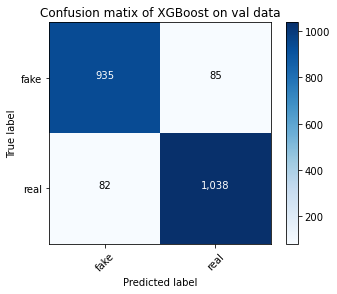

In [63]:
# XGBoost Classifier

# create pipeline
#pipeline = Pipeline([
        #('bow', CountVectorizer(ngram_range=(1, 1))), # count term frequency
        #('tfidf', TfidfTransformer()), # downweight words which appear frequently
        #('c', XGBClassifier(max_depth=3, min_child_weight=3, eta = 0.15000000000000002,n_estimators = 550, scale=1, subsample =0.8500000000000001 )) # classifier
        #('c', XGBClassifier(max_depth=20, min_child_weight=2)) # classifier
        #('c', XGBClassifier(**params, objective='binary:logistic')) # classifier 
        # Best parameters: {'model__max_depth': 10, 'model__min_child_weight': 1, 'model__n_estimators': 100}
    #])

xgb_clf = XGBClassifier(max_depth=3, min_child_weight=3, eta = 0.15000000000000002,n_estimators = 550, scale=1, subsample =0.8500000000000001 )

fit = xgb_clf.fit(X_train,y_train) # train model
print('XGBoost')
print ('val:')
pred_XGB = xgb_clf.predict(X_val) # make predictions

# display results
print_metrics(pred_XGB,y_val)
plot_confusion_matrix(confusion_matrix(y_val,pred_XGB),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of XGBoost on val data')

## #4 Adaptive Boost

In [53]:
# AdaBoost classifier
ada_clf = AdaBoostClassifier(n_estimators=500, random_state=0, learning_rate = 1.0)

# train model
fit = ada_clf.fit(X_train, y_train)

# make predictions
ada_pred = ada_clf.predict(X_val)

In [18]:
import pickle

In [58]:
#save SVM
pkl_filename = "pickle_svm_clf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svm_clf, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
#    pickle_svm_clf = pickle.load(file)

#use pickle_svm_clf as model for unseen data

In [ ]:
# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_svm_clf = pickle.load(file)


    
#use pickle_svm_clf as model for unseen data

In [59]:
#save LG
pkl_filename = "pickle_lg_clf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lr_clf, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
#    pickle_svm_clf = pickle.load(file)

#use pickle_svm_clf as model for unseen data

In [64]:
#save XGB
pkl_filename = "pickle_xgb_clf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb_clf, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
#    pickle_svm_clf = pickle.load(file)

#use pickle_svm_clf as model for unseen data

In [61]:
#save ADA
pkl_filename = "pickle_ada_clf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(ada_clf, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
#    pickle_svm_clf = pickle.load(file)

#use pickle_svm_clf as model for unseen data

In [19]:
# Load from file
with open("pickle_svm_clf.pkl", 'rb') as file:
    pickle_svm_clf = pickle.load(file)

with open("pickle_lg_clf.pkl", 'rb') as file:
    pickle_lr_clf = pickle.load(file)
    
with open("pickle_xgb_clf.pkl", 'rb') as file:
    pickle_xgb_clf = pickle.load(file)
    
with open("pickle_ada_clf.pkl", 'rb') as file:
    pickle_ada_clf = pickle.load(file)

## #5 Voting Classifier

In [20]:
named_estimators = [
    ("SVM", pickle_svm_clf),
    ("Logistic Regression", pickle_lr_clf),
    ("Ada Boost", pickle_ada_clf),
    ("XGB Boosting", pickle_xgb_clf), # for each of the individual models
]

In [65]:
named_estimators = [
    ("SVM", svm_clf),
    ("Logistic Regression", lr_clf),
    ("Ada Boost", ada_clf),
    ("XGB Boosting", xgb_clf), # for each of the individual models
]

/Users/marco/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/marco/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:45:27] WARNING: ../src/learner.cc:576: 
Parameters: { "scale" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:45:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 953   67]
 [  59 1061]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1020
           1       0.94      0.95      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140

Accuracy :  0.9411214953271028
Preciso

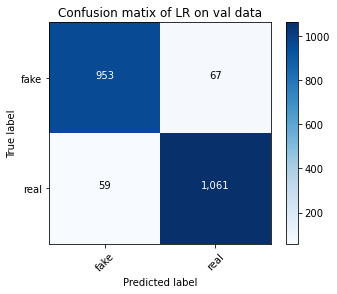

In [21]:
# voting classifier
voting_clf = VotingClassifier(named_estimators, voting = "soft") #soft voting (predicts the class label based on the argmax of the sums of the predicted probabilities)

# fit model
voting_clf.fit(X_train,y_train)

# make prediction
voting_pred = voting_clf.predict(X_val)
# display results
print_metrics(voting_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val,voting_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of voting classifier on val data')

In [22]:
#save VC
pkl_filename = "pickle_voting_clf.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(voting_clf, file)

# Load from file
#with open(pkl_filename, 'rb') as file:
#    pickle_svm_clf = pickle.load(file)

#use pickle_svm_clf as model for unseen data

In [44]:
# voting classifier on test data
voting_pred_test = voting_clf.predict(X_test)
# display results
print_metrics(voting_pred_test, y_test)
plot_confusion_matrix(confusion_matrix(y_test,voting_pred_test),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of # voting classifier on test data')

[[ 942   78]
 [  68 1052]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1020
           1       0.93      0.94      0.94      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140

Accuracy :  0.9317757009345794
Precison :  0.9318493285164533
Recall :  0.9317757009345794
F1 :  0.9317921315265821


/Users/marco/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


TypeError: plot_confusion_matrix() got an unexpected keyword argument 'target_names'

# Evaluation

## #1 SVM

In [ ]:
# display results
print_metrics(svm_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val,svm_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of SVM on val data')

## #2 Logisitic Regression

[[ 950   70]
 [  54 1066]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1020
           1       0.94      0.95      0.95      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140

Accuracy :  0.9420560747663551
Precison :  0.9422086965627371
Recall :  0.9420560747663551
F1 :  0.9420796272266441


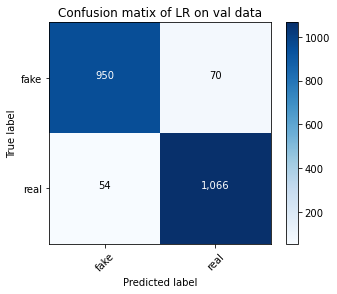

In [30]:
# display results
print_metrics(pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val,pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of LR on val data')

## #3 Extreme Gradient Boost

In [ ]:
# display results
print_metrics(gb_pred, y_val)
plot_confusion_matrix(confusion_matrix(y_val, gb_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of GDBT on val data')

## #4 Adaptive Boost

In [3]:
#without hyperparameters: f1 = 0.8850370706902788
# display results
print_metrics(ada_pred,y_val)
plot_confusion_matrix(confusion_matrix(y_val,ada_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ada on val data')

NameError: name 'ada_pred' is not defined

## #5 Voting Classifier

In [ ]:
# display results
print_metrics(voting_pred,val['label'])
plot_confusion_matrix(confusion_matrix(val['label'],voting_pred),target_names=['fake','real'], normalize = False, \
                      title = 'Confusion matix of Ensemble on val data')

So far, simple SVM outfperforms ensemble learning

# Error Analysis

In [ ]:
# create a df of misclassified posts
val_orig = pd.read_csv('https://raw.githubusercontent.com/smkerr/COVID-fake-news-detection/main/data/Constraint_Val.csv', header=0)
svm_val_misclass_df = val_orig[svm_pred!=y_val]

# inspect df
svm_val_misclass_df.info()

In [ ]:
#error analysis, to compair the false classifications of the different models

false_pred_svm = val[(val["label"] != svm_pred)]
false_pred_gb = val[(val["label"] != gb_pred)]
false_pred_lr = val[(val["label"] != lr_pred)]
false_pred_xg = val[(val["label"] != pred)]
false_pred_ada = val[(val["label"] != ada_pred)]
false_pred_ensemble = val[(val["label"] != voting_pred)]

#common_mistakes = false_pred_svm = false_pred_gb = false_pred_lr = false_pred_xg = false_pred_ada = false_pred_ensemble
print(false_pred_ensemble)



In [ ]:
#print(common_mistakes)
common_mistakes = pd.merge(false_pred_svm, false_pred_ada, on=['tweet'], how='inner')
print(common_mistakes)
common_mistakes.to_csv('/content/drive/MyDrive/Final Project/COVID-fake-news-detection/model/error_analysis/common_mistakes.csv', encoding='utf-8')

In [ ]:
#mount drive to save data
from google.colab import drive
drive.mount('drive')